Best parking allocation (chromosome):
[73, 1, 7, 6, 9, 18, 2, 8, 62, 45, 13, 3, 24, 33, 27, 57, 5, 38, 48, 14, 28, 4, 16, 12, 64, 42, 17, 58, 23, 56, 53, 15, 19, 54, 47, 65, 22, 34, 31, 26, 67, 55, 25, 46, 44, 37, 32, 35, 76, 36]

Total Walking Distance (fitness): 161.65430890438702
Generations run: 54


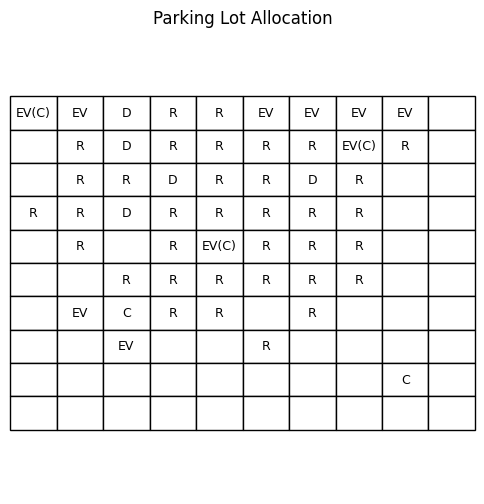

In [5]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np


# Helper Functions

def space_to_coords(space_number):
    #Convert parking space number (1-100) to grid coordinates (row, col) using 1-indexed positions.
    row = (space_number - 1) // 10 + 1
    col = (space_number - 1) % 10 + 1
    return (row, col)

def euclidean_distance(p1, p2):
   #  Compute the Euclidean distance between two points (row, col).
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Problem Data & Parameters

GRID_ROWS = 10
GRID_COLS = 10

# Entrance is at center (given as (5,5) in 1-indexed coordinates)
entrance = (5, 5)

# Charging station coordinates for EVs are
charging_stations = [(1, 1), (2, 8), (5, 5), (7, 3), (9, 9)]

# Number of cars and their types
NUM_CARS = 50
NUM_EV = 10
NUM_DISABLED = 5
NUM_REGULAR = 35

# GA Parameters
POP_SIZE = 100
TOURNAMENT_SIZE = 5
MAX_GENERATIONS = 1000
NO_IMPROVE_LIMIT = 20  # generations with no improvement before stopping

# Penalty weights for priority constraints
EV_PENALTY_WEIGHT = 1.0  # weight for EV distance from nearest charging station


# Chromosome Representation

def generate_chromosome():
    #Generate a random valid chromosome (50 distinct parking spaces).
    #The first 10 are for EVs, next 5 for disabled, remaining 35 for regular.
    return random.sample(range(1, 101), NUM_CARS)

def initialize_population(pop_size):
    #Initialize a population of random chromosomes.
    return [generate_chromosome() for _ in range(pop_size)]

#Fitness Function
def fitness(chromosome):
    """
    Compute the fitness of a chromosome (lower is better).
    This includes the total walking distance for all drivers plus penalties:
      - EV cars: distance to entrance + penalty for distance from charging station
      - Disabled cars: slightly heavier weight for distance to entrance
      - Regular cars: distance to entrance
    """
    total_distance = 0.0

    # Process EV cars (first 10)
    for i in range(NUM_EV):
        space = chromosome[i]
        coords = space_to_coords(space)
        d_entrance = euclidean_distance(coords, entrance)
        d_charge = min(euclidean_distance(coords, cs) for cs in charging_stations)
        # Add both distances (with penalty weight for charging station distance)
        total_distance += d_entrance + EV_PENALTY_WEIGHT * d_charge

    # Process Disabled cars (next 5)
    for i in range(NUM_EV, NUM_EV + NUM_DISABLED):
        space = chromosome[i]
        coords = space_to_coords(space)
        d_entrance = euclidean_distance(coords, entrance)
        # You can apply a heavier weight to emphasize closeness to entrance
        total_distance += 1.2 * d_entrance

    # Process Regular cars (remaining 35)
    for i in range(NUM_EV + NUM_DISABLED, NUM_CARS):
        space = chromosome[i]
        coords = space_to_coords(space)
        d_entrance = euclidean_distance(coords, entrance)
        total_distance += d_entrance

    return total_distance


# GA Operators

def tournament_selection(population, fitnesses, tournament_size=TOURNAMENT_SIZE):
    """Select one chromosome using tournament selection (lower fitness is better)."""
    tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
    tournament.sort(key=lambda x: x[1])  # sort by fitness ascending
    return tournament[0][0]  # return the best chromosome

def uniform_crossover(parent1, parent2):
    #Perform uniform crossover on two parents.Ensure that the offspring remains a valid chromosome (no duplicates).
    child = [None] * NUM_CARS
    gene_source = [random.choice([1, 2]) for _ in range(NUM_CARS)]
    
    for i in range(NUM_CARS):
        if gene_source[i] == 1:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    
    # Fix duplicates by replacing them with missing values
    missing = set(range(1, 101)) - set(child)
    duplicates = [i for i, gene in enumerate(child) if child.count(gene) > 1]
    for idx in duplicates:
        if child.count(child[idx]) > 1:
            child[idx] = missing.pop()
    return child

def swap_mutation(chromosome, mutation_rate=0.1):
    #Perform swap mutation: with probability mutation_rate, swap two random positions.
    mutated = chromosome.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(NUM_CARS), 2)
        mutated[i], mutated[j] = mutated[j], mutated[i]
    return mutated


# Genetic Algorithm Execution
def run_ga():
    population = initialize_population(POP_SIZE)
    best_fitness_val = float('inf')
    best_solution = None
    no_improve_count = 0
    generation = 0

    fitness_history = []

    while generation < MAX_GENERATIONS and no_improve_count < NO_IMPROVE_LIMIT:
        fitnesses = [fitness(chromo) for chromo in population]
        current_best = min(fitnesses)
        best_idx = fitnesses.index(current_best)
        
        # Check for improvement
        if current_best < best_fitness_val:
            best_fitness_val = current_best
            best_solution = population[best_idx]
            no_improve_count = 0
        else:
            no_improve_count += 1

        fitness_history.append(best_fitness_val)
        
        # Create the new population
        new_population = []
        while len(new_population) < POP_SIZE:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = uniform_crossover(parent1, parent2)
            child = swap_mutation(child, mutation_rate=0.1)
            new_population.append(child)
        
        population = new_population
        generation += 1

    return best_solution, best_fitness_val, generation, fitness_history


# Visualization of Parking Allocation
def visualize_parking(chromosome):
    #Creating  a 10x10 grid showing where each car (EV, Disabled, Regular) is parked.
    # Also marking charging stations (C).If a car is placed on a charging station, mark it accordingly (e.g., EV(C)).
    
    # Initialize empty grid
    grid = [['' for _ in range(GRID_COLS)] for _ in range(GRID_ROWS)]
    
    # First, mark all charging stations with 'C'
    for (r, c) in charging_stations:
        # Convert to 0-based indices
        grid[r-1][c-1] = "C"

    # Now place each car in the grid
    for idx, space in enumerate(chromosome):
        row, col = space_to_coords(space)
        # Convert to 0-based
        r, c = row - 1, col - 1
        
        # Determine marker based on car type
        if idx < NUM_EV:
            # It's an EV
            if grid[r][c] == "C":
                # Already marked as charging station
                grid[r][c] = "EV(C)"
            else:
                grid[r][c] = "EV"
        elif idx < NUM_EV + NUM_DISABLED:
            # Disabled
            if grid[r][c] == "C":
                grid[r][c] = "D(C)"
            else:
                grid[r][c] = "D"
        else:
            # Regular
            if grid[r][c] == "C":
                grid[r][c] = "R(C)"
            else:
                grid[r][c] = "R"
    
    # Plot the grid as a table
    fig, ax = plt.subplots(figsize=(6, 6))
    table = plt.table(cellText=grid, loc='center', cellLoc='center')
    table.scale(1, 2)  # adjust scaling if needed
    ax.axis('off')
    plt.title("Parking Lot Allocation")
    plt.show()


if __name__ == "__main__":
    best_solution, best_fit, gens, hist = run_ga()
    print("Best parking allocation (chromosome):")
    print(best_solution)
    print("\nTotal Walking Distance (fitness):", best_fit)
    print("Generations run:", gens)

    visualize_parking(best_solution)
